**IMPORTING THE LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
import string


**READING THE DATA SET**

In [ ]:
data=pd.read_csv("/content/drive/MyDrive/spam_ham_dataset.csv",encoding="latin1")
# Assuming 'data' is the dataset we inspected earlier
df = data.copy()
#checking the head of dataset
df.head()



,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
df.shape

(5171, 4)

In [ ]:
df.size


20684

In [ ]:
df.describe()

,Unnamed: 0,label_num
count,5171.000000,5171.000000
mean,2585.000000,0.289886
std,1492.883452,0.453753
min,0.000000,0.000000
25%,1292.500000,0.000000
50%,2585.000000,0.000000
75%,3877.500000,1.000000
max,5170.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [ ]:
# Dropping unnecessary index column
df.drop(columns=['Unnamed: 0'], inplace=True)

# Checking for any missing data
print(df.isnull().sum())

label        0
text         0
label_num    0
dtype: int64


**EDA ON DATSET**

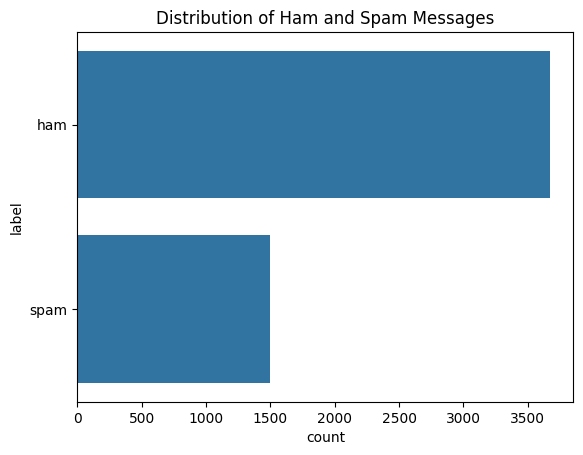

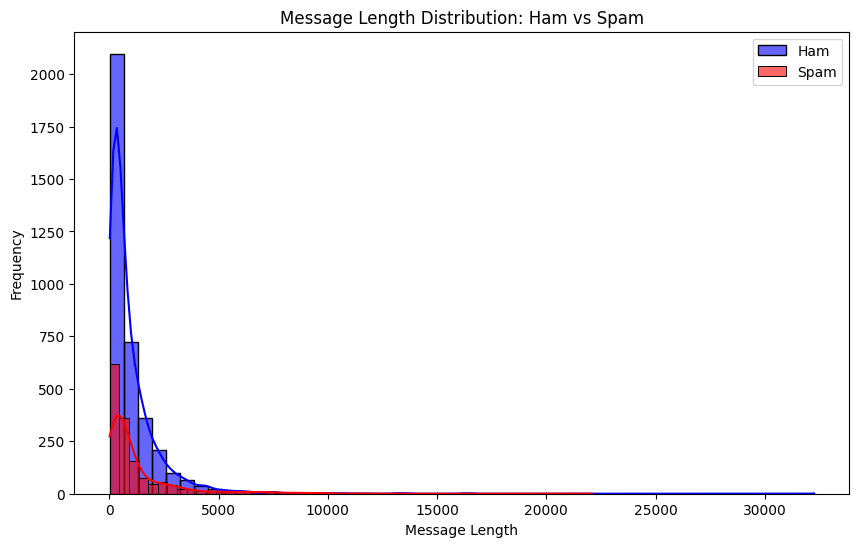

In [ ]:
# Visualize the distribution of spam vs ham
sns.countplot(df['label'])
plt.title('Distribution of Ham and Spam Messages')
plt.show()

#checking the length of each message including spam and ham
df['message_length'] = df['text'].apply(len)

# Plotting the distribution of ham and spam message lengths
plt.figure(figsize=(10,6))

# Ham messages
sns.histplot(df[df['label']=='ham']['message_length'],
             bins=50, color='blue', kde=True, label='Ham', alpha=0.6)

# Spam messages
sns.histplot(df[df['label']=='spam']['message_length'],
             bins=50, color='red', kde=True, label='Spam', alpha=0.6)

plt.title('Message Length Distribution: Ham vs Spam')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


**VISULIZATIONS**

<ipython-input-9-109ef349b403>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='message_length', data=avg_length, palette="Set2")


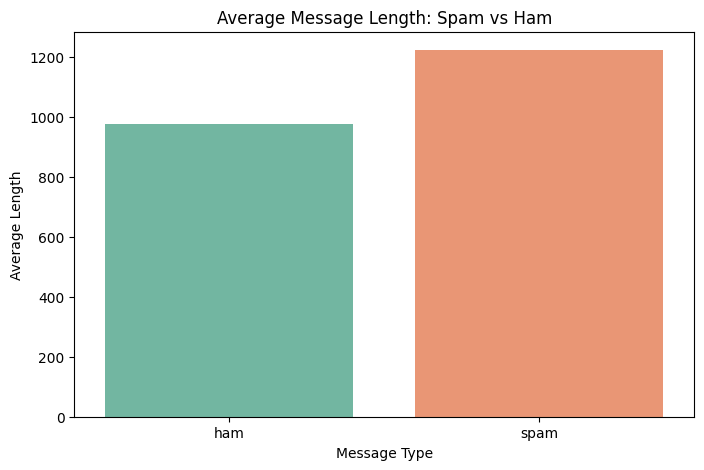

In [ ]:
# Grouping by label and calculating mean message length
avg_length = df.groupby('label')['message_length'].mean().reset_index()

# Plotting
plt.figure(figsize=(8,5))
sns.barplot(x='label', y='message_length', data=avg_length, palette="Set2")
plt.title('Average Message Length: Spam vs Ham')
plt.xlabel('Message Type')
plt.ylabel('Average Length')
plt.show()



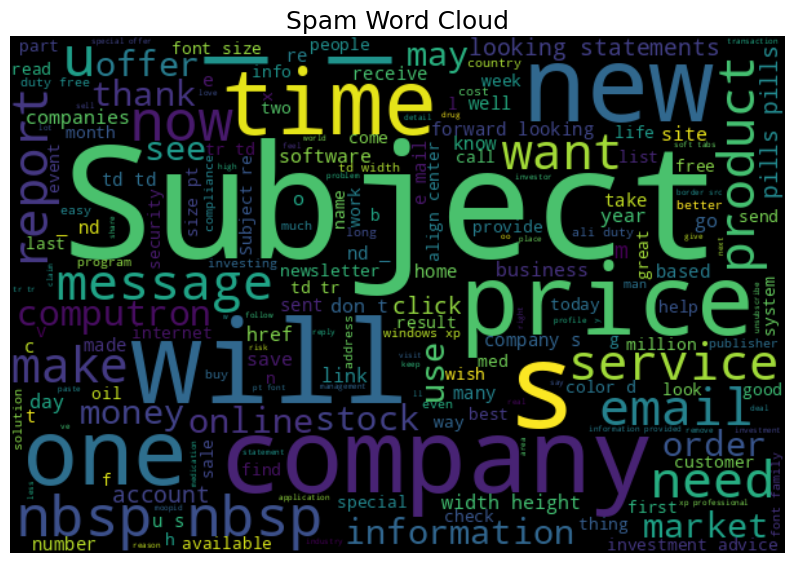

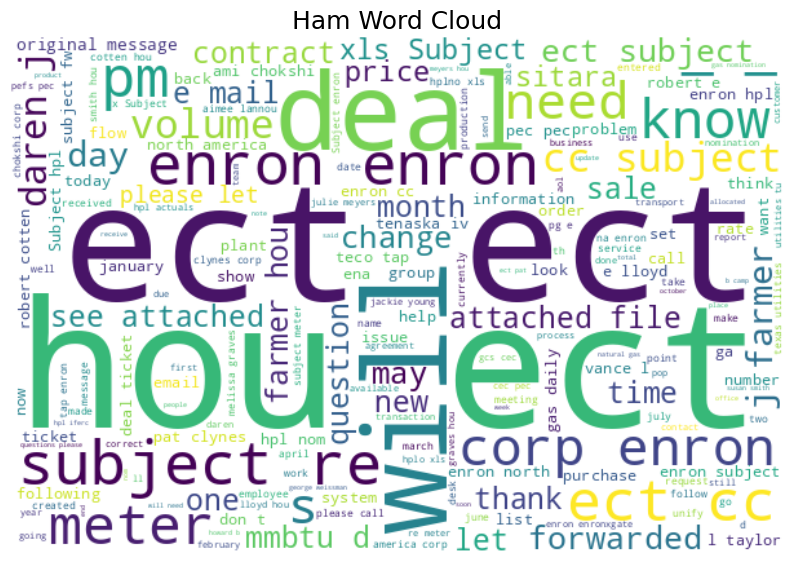

In [ ]:
from wordcloud import WordCloud

# Generating word clouds for spam and ham messages
spam_words = ' '.join(df[df['label']=='spam']['text']) # Use 'text' column instead of 'cleaned_text'
ham_words = ' '.join(df[df['label']=='ham']['text']) # Use 'text' column instead of 'cleaned_text'

# Spam word cloud
spam_wordcloud = WordCloud(width=600, height=400, background_color='black').generate(spam_words)

# Ham word cloud
ham_wordcloud = WordCloud(width=600, height=400, background_color='white').generate(ham_words)

# Plotting the Spam word cloud
plt.figure(figsize=(10,8))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Spam Word Cloud', fontsize=18)
plt.axis('off')
plt.show()

# Plotting the Ham word cloud
plt.figure(figsize=(10,8))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Ham Word Cloud', fontsize=18)
plt.axis('off')
plt.show()




**DATA PREPROCESSING (CLEANING THE TEXT)**

In [ ]:
# Function to clean the text
def clean_text(text):
    text = text.lower()  # convert to lowercase
    text = re.sub('\[.*?\]', '', text)  # remove text in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text)  # remove links
    text = re.sub('<.*?>+', '', text)  # remove HTML tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # remove punctuation
    text = re.sub('\n', '', text)  # remove newline characters
    text = re.sub('\w*\d\w*', '', text)  # remove words containing numbers
    return text

# Apply the cleaning function to the 'text' column
df['cleaned_text'] = df['text'].apply(clean_text)

# Display the cleaned text
df[['text', 'cleaned_text']].head()


,text,cleaned_text
0,Subject: enron methanol ; meter # : 988291\r\n...,subject enron methanol meter \rthis is a fo...
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",subject hpl nom for january \r see attached ...
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",subject neon retreat\rho ho ho we re around ...
3,"Subject: photoshop , windows , office . cheap ...",subject photoshop windows office cheap mai...
4,Subject: re : indian springs\r\nthis deal is t...,subject re indian springs\rthis deal is to bo...


**BUILDING THE COUNT VECTORS WITH CountVectorizer**

In [ ]:
# Initialize CountVectorizer
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the cleaned text data
X = vectorizer.fit_transform(df['cleaned_text'])

# Convert the label into binary format
y = df['label_num']
#print(y) optional to check the required label is displaying or not


**SPLITTING THE DATA INTO TRAINING AND TESTING SETS**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**MODEL BUILDING (NAVIE BAYES)**

In [ ]:
# Initialize and train the model
model = MultinomialNB()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


**Evaluation of the Model**

Accuracy: 97.58%
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       742
           1       0.96      0.96      0.96       293

    accuracy                           0.98      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.98      0.98      0.98      1035



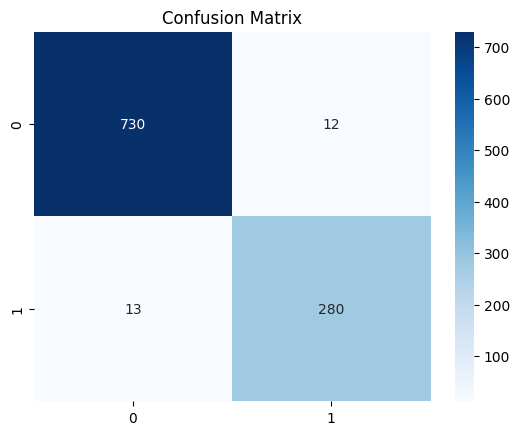

[[730  12]
 [ 13 280]]


In [ ]:
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[730  12]
 [ 13 280]]


**TESTING WITH NEW DATA**

In [ ]:
# Assuming the model is already trained

# Define a new SMS message to test
random_sms = ["Congratulations! You've won a free ticket to Bahamas. Call now to claim your prize!"]
# or else we can give input on runtime
# Vectorize the new SMS message using the same vectorizer used for training data
random_sms_counts = vectorizer.transform(random_sms) # Use the trained vectorizer to transform the new SMS

# Predict whether it's spam (1) or ham (0)
prediction = model.predict(random_sms_counts) # Use the transformed data for prediction

# Output the result
if prediction[0] == 1:
    print("The message is SPAM.")
else:
    print("The message is NOT SPAM.")

The message is SPAM.


**SAVING THE MODEL USING PICKLE**

In [ ]:
import pickle

# Save the model using pickle
with open('sms_spam_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save the vectorizer
with open('vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)


In [ ]:
with open('sms_spam_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

with open('vectorizer.pkl', 'rb') as vectorizer_file:
    vectorizer = pickle.load(vectorizer_file)


** **